In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# библиотека для работы с временными рядами, seaborn и matplotlib очень долго отрисовывают график ВР
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
data = data[['traffic_volume', 'date_time', 'holiday', 'temp']]
data.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [3]:
data.isnull().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  48204 non-null  int64  
 1   date_time       48204 non-null  object 
 2   holiday         48204 non-null  object 
 3   temp            48204 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


Посмотрим, какие праздники есть

In [5]:
data.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

Заменим "None" в holiday на 0/1 (праздник или не праздник), т.е. сделаем допущение, что праздники одинаково влияют на загруженность метро

In [6]:
data.holiday = data.holiday.apply(lambda x: 0 if x == 'None' else 1)

In [7]:
data.describe()

,traffic_volume,holiday,temp
count,48204.000000,48204.000000,48204.000000
mean,3259.818355,0.001265,281.205870
std,1986.860670,0.035551,13.338232
min,0.000000,0.000000,0.000000
25%,1193.000000,0.000000,272.160000
50%,3380.000000,0.000000,282.450000
75%,4933.000000,0.000000,291.806000
max,7280.000000,1.000000,310.070000


Проверка на то, что есть дубликаты

In [8]:
data.shape[0] == data.drop_duplicates().shape[0]

False

Удаляем дубликаты

In [9]:
data = data.drop_duplicates(subset='date_time')
data['date_time'] = pd.to_datetime(data['date_time'])

In [10]:
data.shape[0] == data.drop_duplicates().shape[0]

True

Убедимся, что есть пропуски в датах

In [11]:
data['date_time'] = pd.to_datetime(data['date_time'])

<Figure size 1500x600 with 0 Axes>

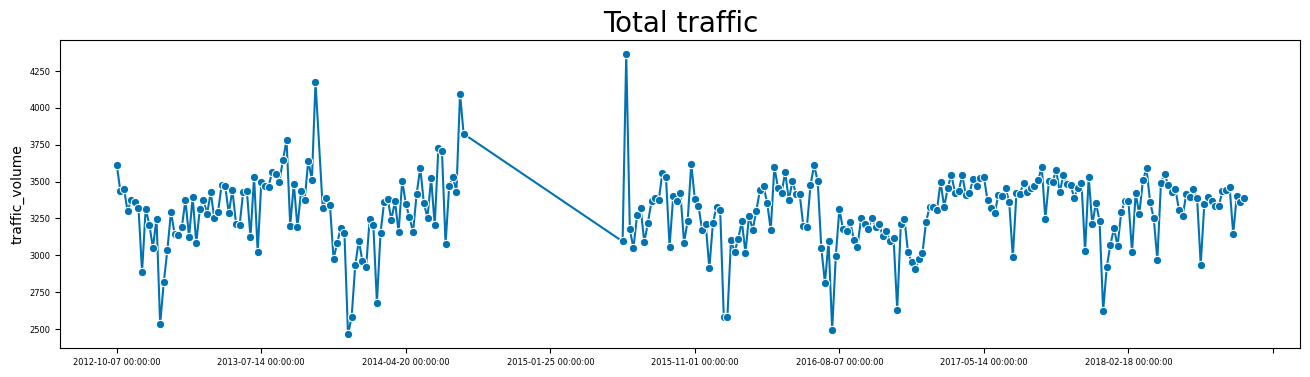

In [12]:
plt.figure(figsize=(15, 6))
y = data.set_index('date_time')['traffic_volume'].resample('W').mean()

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

Виден пробел где-то в районе 2015 года размером в год, искусственно восстанавливать такой большой кусок не кажется хорошей идеей. Поэтому предположу, что данных с 1 января 2016 будет достаточно, к тому же эти данные более актуальны.  
Восстановим пропуски с помощью линейной интерполяции.  

In [13]:
data_crop = data.loc[data['date_time'] >= '2016-01-01 00:00:00']
data_crop.shape

(23084, 4)

In [14]:
# Определим диапазон по началу и концу дат в данных
date_range = pd.date_range(
    start=data_crop['date_time'].min(),
    end=data_crop['date_time'].max(),
    freq='H'
)
dates = pd.DataFrame(date_range, columns=['date_time'])
dates['date_time'] = pd.to_datetime(dates['date_time'])

# Соединим восстановленные даты с данными по совпадению даты
data_merged = dates.merge(data_crop, left_on='date_time', right_on='date_time', how='outer')
data_merged = data_merged[['date_time', 'traffic_volume', 'holiday', 'temp']]

data_merged.shape

(24096, 4)

In [15]:
# Восстановим пропуски методом ffil, т.е. на основе предыдущих значений
data_interpolated = data_merged[['traffic_volume', 'holiday', 'temp']].interpolate(method='ffill')

# Обновим значения датасета в восстановленных столбцах
data_merged[['traffic_volume', 'holiday', 'temp']] = data_interpolated[['traffic_volume', 'holiday', 'temp']]

# Вынесем восстановленный датасет в отдельную переменную
data_final = data_merged
data_final.shape

(24096, 4)

Посмотрим на трафик за одну случайно выбранную неделю (взял с начала датасета, но пропустил новогодние праздники)

<Figure size 1500x600 with 0 Axes>

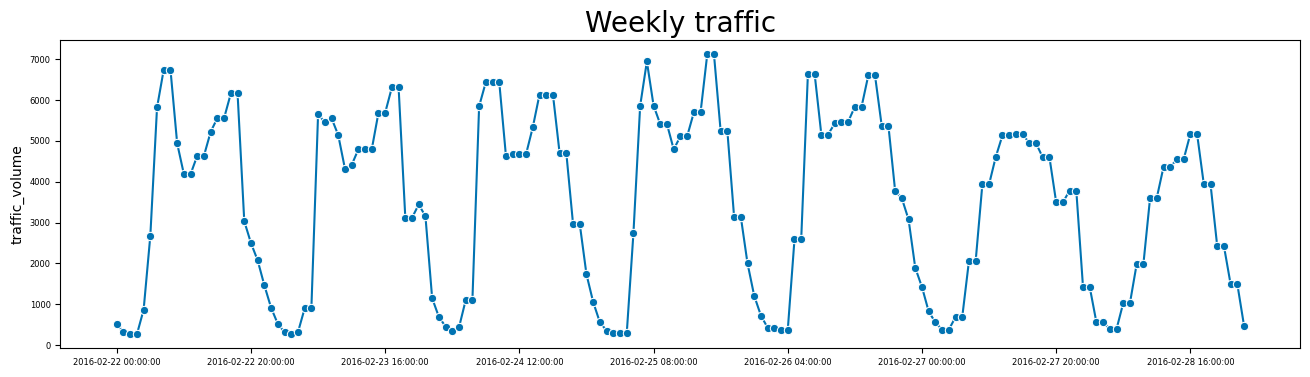

In [16]:
plt.figure(figsize=(15, 6))
y = data_final.set_index('date_time')['traffic_volume'].loc['2016-02-22 00:00:00':'2016-02-29 00:00:00']

plot_series(y)
plt.title('Weekly traffic', fontsize=20, color='black')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()

Хорошо видна периодичность пиков, выделяются выходные дни и часы пик.

Теперь выделим дополнительные признаки из времени, такие как: день недели, час, месяц.

In [17]:
def create_datetime_features(df):
    df['weekday'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    return df

data_final = data_final.set_index('date_time')
create_datetime_features(data_final)

,traffic_volume,holiday,temp,weekday,hour,month
date_time,,,,,,
2016-01-01 00:00:00,1513.0,1.0,265.94,4,0,1
2016-01-01 01:00:00,1550.0,0.0,266.00,4,1,1
2016-01-01 02:00:00,1550.0,0.0,266.00,4,2,1
2016-01-01 03:00:00,719.0,0.0,266.01,4,3,1
2016-01-01 04:00:00,533.0,0.0,264.80,4,4,1
...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,283.45,6,19,9
2018-09-30 20:00:00,2781.0,0.0,282.76,6,20,9
2018-09-30 21:00:00,2159.0,0.0,282.73,6,21,9


Также выделим лаги, т.е. задержку события. Сдвигаем целевую переменную на 10 шагов назад во времени.

In [18]:
def create_lags(df):
    for step in range(14, 154, 14):
        target_map = df['traffic_volume'].to_dict()
        df[f'lag_{step}'] = (df.index - pd.Timedelta(f'{step} days')).map(target_map)
    return df

create_lags(data_final)

,traffic_volume,holiday,temp,weekday,hour,month,lag_14,lag_28,lag_42,lag_56,lag_70,lag_84,lag_98,lag_112,lag_126,lag_140
date_time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1513.0,1.0,265.94,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,1550.0,0.0,266.00,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,1550.0,0.0,266.00,4,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,719.0,0.0,266.01,4,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,533.0,0.0,264.80,4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,283.45,6,19,9,3400.0,3098.0,3792.0,3684.0,3661.0,3969.0,3438.0,3010.0,2830.0,3256.0
2018-09-30 20:00:00,2781.0,0.0,282.76,6,20,9,3092.0,3115.0,3213.0,3316.0,3135.0,3571.0,3187.0,2979.0,2825.0,3049.0
2018-09-30 21:00:00,2159.0,0.0,282.73,6,21,9,2623.0,2669.0,2682.0,2735.0,2803.0,2948.0,2556.0,2353.0,2656.0,2586.0


Разделим данные на тренировочные и валидационные

Train shape = (23760, 17)  Test shape = (336, 17)


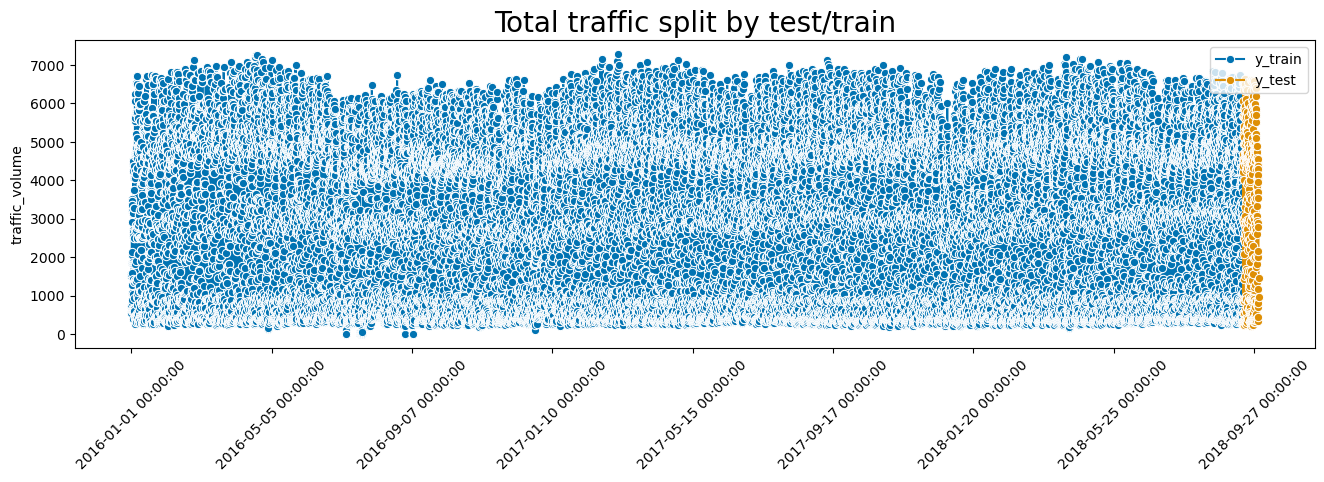

In [33]:
y_train, y_test = temporal_train_test_split(data_final, test_size=24*7*2)

plot_series(y_train['traffic_volume'], y_test['traffic_volume'], labels=["y_train", "y_test"])
plt.xticks(rotation = 45)
plt.title('Total traffic split by test/train', fontsize=20, color='black')
print(f'Train shape = {y_train.shape}  Test shape = {y_test.shape}')

Построим базовый прогноз на основе средних значений по часам и по дням

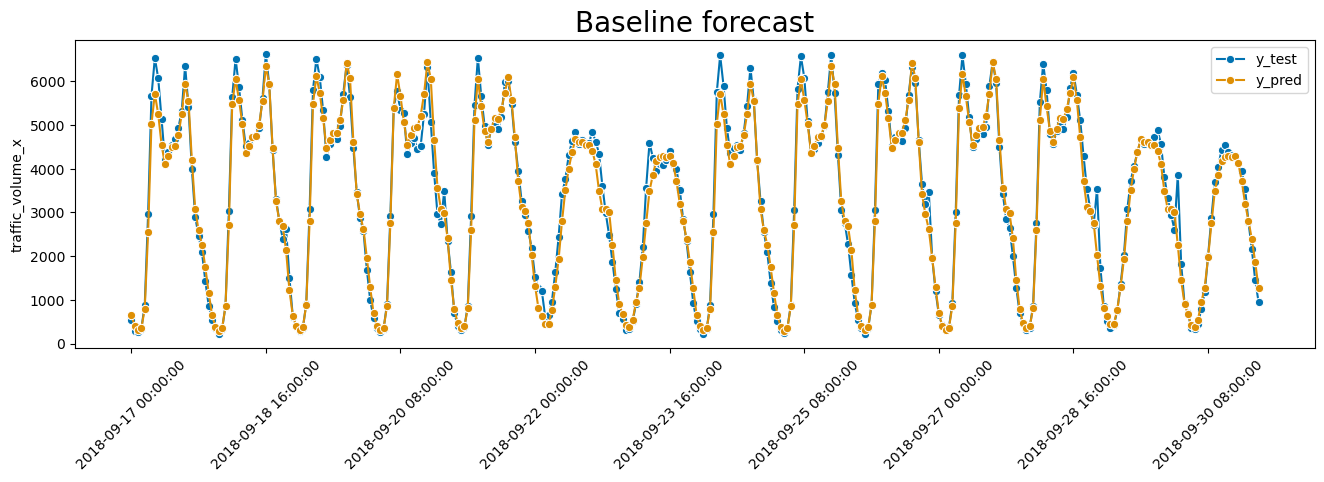

In [20]:
avg = y_train.groupby(['weekday', 'hour'])['traffic_volume'].mean()

test_baseline = y_test.copy()
test_baseline = test_baseline.join(
    avg, 
    on=['weekday', 'hour'], 
    how='inner', 
    lsuffix='_x', 
    rsuffix='_y'
)

plot_series(
    test_baseline['traffic_volume_x'].sort_index(), 
    test_baseline['traffic_volume_y'].sort_index(), 
    labels=["y_test", "y_pred"]
)
plt.xticks(rotation=45)
plt.title('Baseline forecast', fontsize=20, color='black')
plt.show()

In [21]:
scoring_table = pd.DataFrame()
new_row = {
    'Test':'Avg_baseline', 
    'RMSE': round(np.sqrt(mean_squared_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y'])), 2),
    'MAE': round(mean_absolute_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']), 2),
    'MAPE': round(mean_absolute_percentage_error(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']), 4),
    'R2_score': round(r2_score(test_baseline['traffic_volume_x'],test_baseline['traffic_volume_y']), 4)
}
scoring_table = scoring_table.append(new_row, ignore_index=True)
scoring_table.set_index('Test').sort_values(by = 'R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762


Получилось достаточно неплохо. Посмотрим, как справятся остальные модели.

**SARIMA**

C:\Users\mikhail.klyazhev\Anaconda\envs\ds_base\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\mikhail.klyazhev\Anaconda\envs\ds_base\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\mikhail.klyazhev\Anaconda\envs\ds_base\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


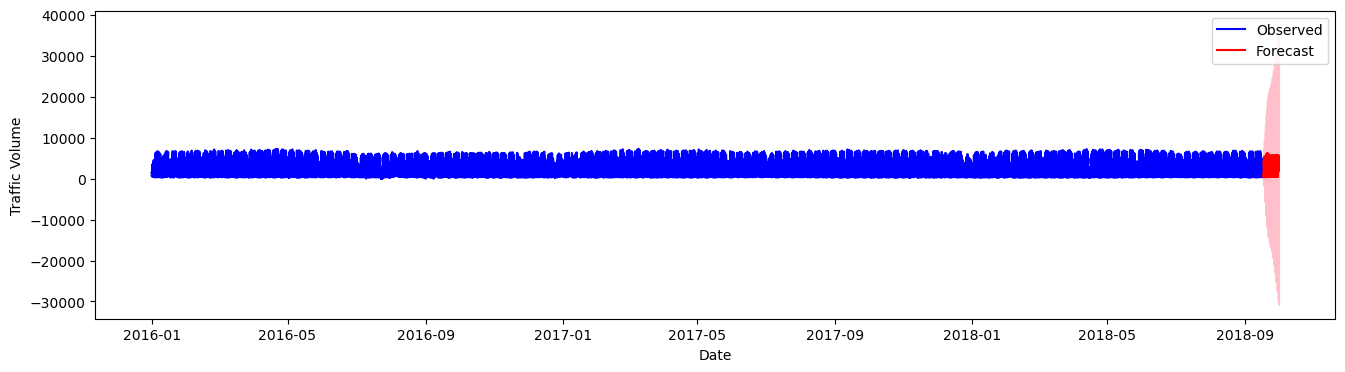

In [23]:
import statsmodels.api as sm

# SARIMA parameters (p, d, q, P, D, Q, S)
p = 1  # Non-seasonal AutoRegressive order
d = 1  # Non-seasonal differencing order
q = 1  # Non-seasonal Moving Average order
P = 1  # Seasonal AutoRegressive order
D = 1  # Seasonal differencing order
Q = 7  # Seasonal Moving Average order
S = 24  # Seasonal period (24 hours in a day for daily data)

sarima_model = sm.tsa.SARIMAX(
    y_train[-24*7*3:]['traffic_volume'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, S),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()

# Прогноз на 2 недели вперед
forecast_period = 24 * 14
forecast = sarima_result.get_forecast(steps=forecast_period)

forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Отрисуем данные и прогноз
plt.figure(figsize=(16, 4))
plt.plot(y_train['traffic_volume'], label='Observed', color='blue')
plt.plot(forecast_values.index, forecast_values.values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [26]:
new_row = {
    'Test': 'SARIMA',
    'RMSE': round(np.sqrt(mean_squared_error(y_test['traffic_volume'], forecast_values)), 2),
    'MAE': round(mean_absolute_error(y_test['traffic_volume'], forecast_values), 2),
    'MAPE': round(mean_absolute_percentage_error(y_test['traffic_volume'], forecast_values), 4),
    'R2_score': round(r2_score(y_test['traffic_volume'], forecast_values), 4)
}
scoring_table = scoring_table.append(new_row, ignore_index=True)
scoring_table.set_index('Test').sort_values(by='R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
Avg_baseline,302.64,208.69,0.0881,0.9762
SARIMA,852.46,558.00,0.2777,0.8114


**LGBM**

In [28]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

X_train = y_train.drop('traffic_volume', axis=1)
y_train1 = y_train['traffic_volume']

X_test = y_test.drop('traffic_volume', axis=1)
y_test1 = y_test['traffic_volume']


scaler_lgbm = StandardScaler()
X_train = scaler_lgbm.fit_transform(X_train)
X_test = scaler_lgbm.transform(X_test)

model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train, y_train1)
y_pred = model_lgbm.predict(X_test)

new_row = {
    'Test':'LGBM', 
    'RMSE': round(np.sqrt(mean_squared_error(y_test1.values, y_pred)), 2),
    'MAE': round(mean_absolute_error(y_test1.values, y_pred), 2),
    'MAPE': round(mean_absolute_percentage_error(y_test1.values, y_pred), 4),
    'R2_score': round(r2_score(y_test1.values, y_pred),4)
}
scoring_table = scoring_table.append(new_row, ignore_index=True)
scoring_table.set_index('Test').sort_values(by='R2_score', ascending=False)

,RMSE,MAE,MAPE,R2_score
Test,,,,
LGBM,284.87,185.65,0.0795,0.9789
Avg_baseline,302.64,208.69,0.0881,0.9762
SARIMA,852.46,558.00,0.2777,0.8114


Построим прогноз на будущее

In [29]:
future_range = pd.date_range(
    start='2018-10-01 00:00:00', 
    periods=24*7*2,
    freq='H'
)
future_df = pd.DataFrame(index=future_range)
future_df['future'] = True
data_final['future'] = False
df_fin_future = pd.concat([data_final, future_df])

df_fin_future = create_datetime_features(df_fin_future)
df_fin_future = create_lags(df_fin_future)

df_fin_future['holiday'] = 0
df_future_toforecast = df_fin_future[df_fin_future['future'] == True]

In [30]:
X_train_temp = y_train.drop(['traffic_volume', 'temp'], axis=1)
y_train_temp = y_train['temp']

scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_temp)
model_temp = LGBMRegressor()
model_temp.fit(X_train_temp, y_train_temp)

X_test_temp = df_future_toforecast.drop(['traffic_volume', 'temp', 'future'], axis=1)
temp_pred = model_temp.predict(X_test_temp)

df_future_toforecast['temp'] = temp_pred
df_future_toforecast = df_future_toforecast.drop(['traffic_volume','future'], axis=1)
df_future_toforecast.head(5)

,holiday,temp,weekday,hour,month,lag_14,lag_28,lag_42,lag_56,lag_70,lag_84,lag_98,lag_112,lag_126,lag_140
2018-10-01 00:00:00,0,265.568170,0,0,10,550.0,962.0,922.0,703.0,714.0,676.0,652.0,642.0,1088.0,598.0
2018-10-01 01:00:00,0,266.702889,0,1,10,280.0,694.0,473.0,421.0,402.0,423.0,422.0,396.0,559.0,366.0
2018-10-01 02:00:00,0,264.855857,0,2,10,260.0,421.0,346.0,327.0,354.0,320.0,331.0,291.0,440.0,243.0
2018-10-01 03:00:00,0,264.855857,0,3,10,344.0,310.0,369.0,375.0,355.0,348.0,406.0,310.0,332.0,308.0
2018-10-01 04:00:00,0,264.855857,0,4,10,880.0,325.0,941.0,890.0,957.0,903.0,902.0,873.0,314.0,875.0


In [31]:
X_pred = scaler_lgbm.transform(df_future_toforecast)

all_models = {}
for alpha in [0.05, 0.95]:
    lgbm = LGBMRegressor(objective='quantile', alpha=alpha, metric='quantile')
    all_models['q %1.2f' % alpha] = lgbm.fit(X_train, y_train1)
y_lower = all_models['q 0.05'].predict(X_pred)
y_upper = all_models['q 0.95'].predict(X_pred)


df_future_toforecast['LGBM'] = model_lgbm.predict(X_pred)

<Figure size 1500x800 with 0 Axes>

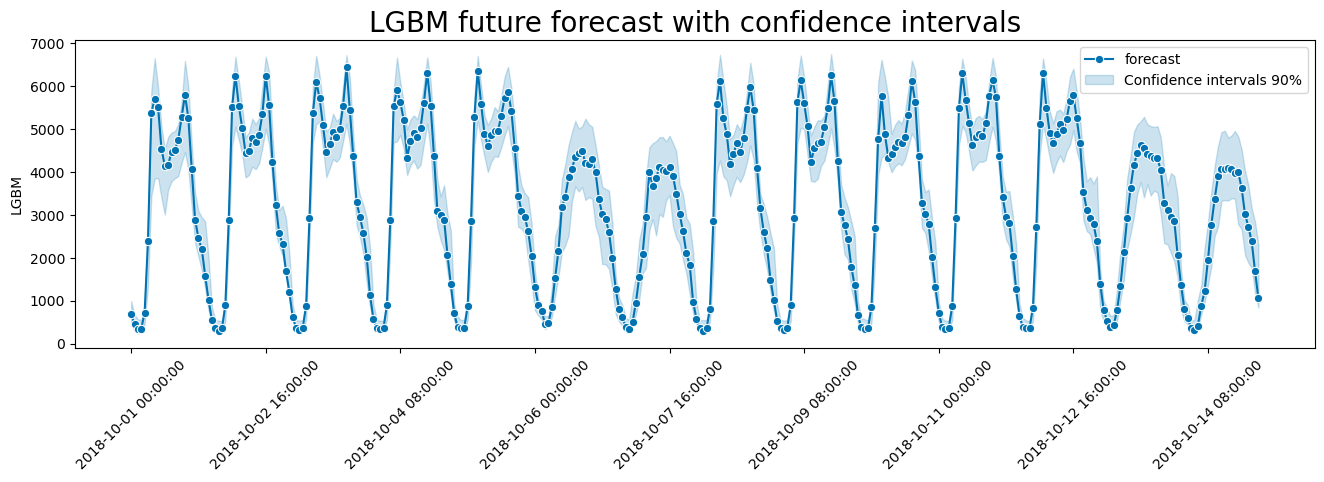

In [32]:
plt.figure(figsize = (15,8))
fig, ax = plot_series( 
  df_future_toforecast['LGBM'], 
  labels=['forecast'], 
)
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y1 = y_lower,
    y2 = y_upper,
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f'Confidence intervals 90%'
)


ax.legend(loc = 'best')
plt.title('LGBM future forecast with confidence intervals', fontsize=20, color='black')
plt.xticks(rotation=45)
plt.show()

LightGBM справился лучше всех.